# Debug Bert notebook
- [x] trivial case, with predicting shifted tokens, instead of mlm.
- [x] trivial case, of classifying presence of marker token, at a random position.

In [1]:
%load_ext autoreload
%autoreload 2

import tokentango

TokenTango


In [2]:
import torch
from torch.optim import Adam, AdamW
from torch import nn, functional as F
from plotly import express as px
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.utils as nn_utils
import os
import uuid
#from muon import MuonWithAuxAdam
#import copy

In [3]:
random_id = str(uuid.uuid4())[:8]

In [4]:
device = torch.device("mps")

In [5]:
# 1. Embeddings padding_idx = 0, might conflict with cls, or other tokens? (model.py)
# 2. xs, masks and cls classes are all made with seperate calls to train_test_split (in bert_from_scratch.py)
#    so maybe the cls' dont match the text

num_samples = 10**5 // 5 # 20% of the sample space

xs = torch.randint(low=1, high=10, size=(num_samples,5), dtype=torch.int32)
xs = torch.cat([torch.zeros(num_samples, 1, dtype=torch.int), xs], dim=1).to(device)

ys = xs.clone()
cls_label = [float(any(n == 1 for n in xs[i,:])*2-1) for i in range(num_samples)]
print(sum(float(any(n == 1 for n in xs[i,:])) for i in range(num_samples))/len(cls_label))

split_at = int(0.8 * num_samples)

train_x = xs[:split_at, :]
train_y = ys[:split_at, :]
train_cls = cls_label[:split_at]

test_x = xs[split_at:, :]
test_y = ys[split_at:, :]
test_cls = cls_label[split_at:]

0.44585


In [6]:
sum(torch.Tensor(test_cls) == 1).item() / len(test_cls), sum(torch.Tensor(train_cls) == 1).item() / len(train_cls)

(0.45825, 0.44275)

In [7]:
model = tokentango.BertClassifier(6, 10, device).to(device)
#torch.save(model.state_dict(), f"brute_convergence/{random_id}.pth")
#state_dict = torch.load("brute_convergence/did_converge_afcc5594.pth")
#filtered_dict = state_dict #{k: v for k, v in state_dict.items() if not k.startswith('embeddings')}
#print(set([n.split(".")[0] for n in filtered_dict.keys()]))

# Update model's current state_dict
#model_state_dict = model.state_dict()
#model_state_dict.update(filtered_dict)

# Load the updated state_dict into the model
#model.load_state_dict(model_state_dict)

model.train()
# 3. Maybe change named_parameters to parameters? (also in bert_from_scratch.py)
optimizer = AdamW(model.parameters(), lr = 1e-4, weight_decay=0.01)
#optimizer = Adam(model.parameters(), lr = 1e-5)

In [8]:
#body = [*model.encoder_layer.parameters(), *model.transformer_encoder.parameters(), *model.preclassifier.parameters()]
#head = [*model.classifier.parameters()]#, model.distribution.parameters()]
#embed = [*model.embeddings.parameters()]#, *model.positional_encoding.parameters()]
#
#hidden_weights = [p for p in body if p.ndim >= 2]
#hidden_gains_biases = [p for p in body if p.ndim < 2]
#nonhidden_params = [*head, *embed]
#
#param_groups = [
#    dict(params=hidden_weights, use_muon=True,
#         lr=0.02, weight_decay=0.01),
#    dict(params=hidden_gains_biases+nonhidden_params, use_muon=False,
#         lr=3e-4, betas=(0.9, 0.95), weight_decay=0.01),
#]
#
#optimizer = MuonWithAuxAdam(param_groups)

In [9]:
num_epochs = 128
mlm_losses = []
cls_losses = []
batch_size = 32
loss = 1

# Initialize variables for tracking best model
best_cls_loss = float('inf')
best_model_state = None

for epoch in range(0, num_epochs):
    epoch_cls_losses = []
    
    for idx in range(0, split_at//batch_size, batch_size):
        #if loss < 0.04:
        #    continue
        optimizer.zero_grad()
        x = train_x[idx:idx+batch_size,:]
        y = train_y[idx:idx+batch_size,:]
        cls_class = torch.tensor(train_cls[idx:idx+batch_size]).to(device)
        hidden = model.hidden(y)
        loss_cls = model.classify_loss(hidden, cls_class)
        #loss_mlm = model.mlm_loss(hidden, y)
        loss = loss_cls# + loss_mlm
        
        #mlm_losses.append(loss_mlm.cpu().item())
        cls_losses.append(loss_cls.cpu().item())
        epoch_cls_losses.append(loss_cls.cpu().item())
        
        loss.backward()
        #nn_utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    
    # Calculate average loss for this epoch
    avg_epoch_cls_loss = sum(epoch_cls_losses) / len(epoch_cls_losses)
    
    # Check if this is the best model so far
    if avg_epoch_cls_loss < best_cls_loss:
        best_cls_loss = avg_epoch_cls_loss
        # Save the best model state (deep copy to avoid reference issues)
        best_model_state = {key: value.cpu().clone() for key, value in model.state_dict().items()}
        print(f"New best model at epoch {epoch+1} with cls_loss: {best_cls_loss:.6f}")

# Load the best model weights after training
if best_model_state is not None:
    # Move state dict back to the appropriate device
    for key in best_model_state:
        best_model_state[key] = best_model_state[key].to(device)
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with cls_loss: {best_cls_loss:.6f}")
else:
    print("No best model found - keeping current weights")

New best model at epoch 1 with cls_loss: 0.480842
New best model at epoch 5 with cls_loss: 0.472797
New best model at epoch 6 with cls_loss: 0.399649
New best model at epoch 7 with cls_loss: 0.241327
New best model at epoch 8 with cls_loss: 0.142377
New best model at epoch 9 with cls_loss: 0.119738
New best model at epoch 10 with cls_loss: 0.085361
New best model at epoch 11 with cls_loss: 0.070583
New best model at epoch 13 with cls_loss: 0.065809
New best model at epoch 14 with cls_loss: 0.044557
New best model at epoch 15 with cls_loss: 0.032209
New best model at epoch 17 with cls_loss: 0.023158
New best model at epoch 18 with cls_loss: 0.019869
New best model at epoch 19 with cls_loss: 0.012616
New best model at epoch 21 with cls_loss: 0.007037
New best model at epoch 30 with cls_loss: 0.006511
New best model at epoch 46 with cls_loss: 0.006493
New best model at epoch 47 with cls_loss: 0.006410
New best model at epoch 49 with cls_loss: 0.005762
New best model at epoch 50 with cls_l

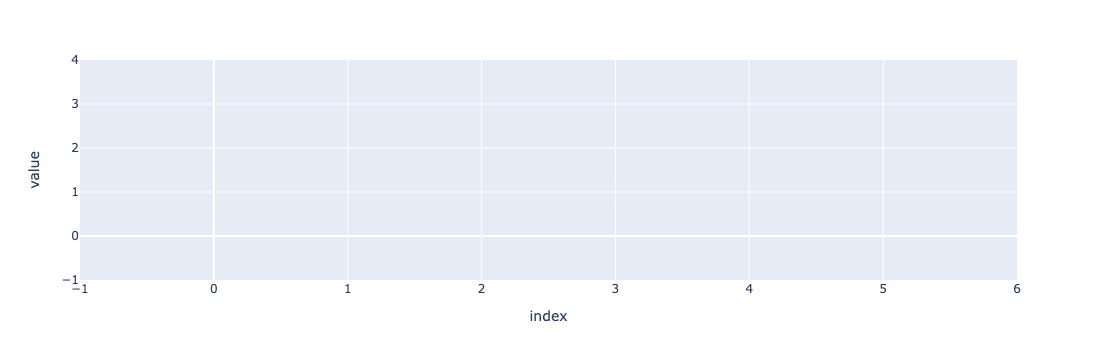

In [10]:
px.line(mlm_losses)

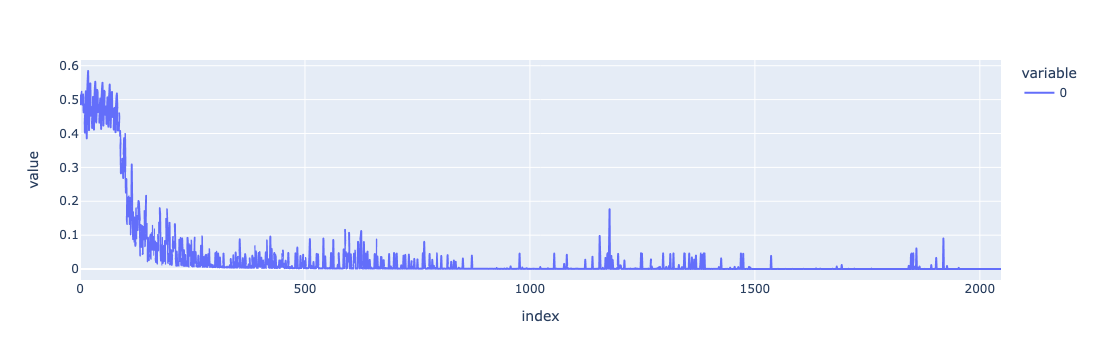

In [11]:
px.line(cls_losses)

In [12]:
correct = 0
avg_loss = 0
for idx in range(num_samples-split_at):
    x = test_y[idx:idx+1,:]
    hidden = model.hidden(x)
    output = model.classify(hidden)
    avg_loss += model.classify_loss(hidden, torch.tensor(test_cls[idx:idx+1]).to(device)).cpu().item()
    print(f"{output.cpu().detach().item():.2f} [{test_cls[idx]}] {x.cpu().detach().tolist()}")
    #correct += int((output.cpu().detach().item()<0.5) == (test_cls[idx]<0.5))
    correct += int(np.sign(output.cpu().detach().item()) == np.sign(test_cls[idx]))

accuracy = correct / (num_samples-split_at)*100
avg_loss /= num_samples-split_at
print(f'{accuracy}%')

#random_id = len([f for f in os.listdir('.') if os.path.isfile(f)])

if accuracy > 87:
    file_name = f"did_converge_{random_id}"
else:
    file_name = f"not_converge_{random_id}"

#torch.save(model.state_dict(), f"brute_convergence/{file_name}.pth")

#fig = px.line(cls_losses)
#fig.write_image(f"brute_convergence/{file_name}.png")

0.98 [1.0] [[0, 1, 2, 2, 1, 5]]
0.98 [-1.0] [[0, 4, 8, 5, 8, 4]]
0.98 [-1.0] [[0, 9, 6, 3, 4, 7]]
0.98 [1.0] [[0, 2, 7, 8, 1, 1]]
0.98 [-1.0] [[0, 3, 4, 5, 4, 8]]
0.97 [-1.0] [[0, 4, 7, 4, 4, 9]]
-0.93 [1.0] [[0, 8, 5, 9, 1, 8]]
0.96 [1.0] [[0, 2, 2, 4, 1, 5]]
-0.97 [1.0] [[0, 1, 9, 9, 6, 9]]
-0.96 [1.0] [[0, 3, 5, 4, 1, 2]]
0.97 [1.0] [[0, 3, 9, 6, 7, 1]]
-0.95 [1.0] [[0, 7, 9, 2, 1, 7]]
0.98 [-1.0] [[0, 4, 7, 6, 5, 2]]
0.97 [-1.0] [[0, 3, 5, 5, 8, 3]]
0.98 [-1.0] [[0, 8, 9, 6, 2, 6]]
0.97 [1.0] [[0, 6, 1, 8, 7, 8]]
0.98 [1.0] [[0, 6, 7, 7, 1, 2]]
0.98 [-1.0] [[0, 7, 9, 5, 7, 3]]
0.98 [-1.0] [[0, 2, 8, 9, 9, 2]]
0.98 [-1.0] [[0, 8, 2, 6, 6, 5]]
0.97 [1.0] [[0, 1, 3, 8, 3, 9]]
0.94 [1.0] [[0, 4, 2, 1, 3, 8]]
0.98 [1.0] [[0, 1, 6, 2, 6, 8]]
0.98 [-1.0] [[0, 6, 4, 6, 3, 7]]
0.97 [-1.0] [[0, 3, 8, 2, 7, 3]]
0.97 [1.0] [[0, 1, 7, 7, 6, 6]]
-0.98 [1.0] [[0, 7, 5, 9, 1, 5]]
0.98 [-1.0] [[0, 4, 9, 3, 8, 2]]
0.61 [1.0] [[0, 7, 7, 1, 1, 4]]
0.97 [-1.0] [[0, 2, 7, 3, 8, 7]]
0.98 [-1.0] [[0, 7, 4

In [13]:
print(f'{file_name} {accuracy}% {avg_loss}')

not_converge_9fa30007 33.300000000000004% 0.9683013765389223
